In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv1D, MaxPooling2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, add, Cropping2D, ReLU, BatchNormalization, Lambda, PReLU
from tensorflow.keras.layers import Concatenate, Reshape, MaxPooling1D, Cropping1D, ZeroPadding1D, Flatten
from tensorflow.keras.layers import AveragePooling2D, LSTM, RepeatVector, TimeDistributed, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence, OrderedEnqueuer
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import activations
from tensorflow.keras.backend import expand_dims

import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import random

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)
#tf.keras.backend.set_floatx('float16')

In [2]:
height_x = 120
width_x = 133
channels = 3
shape_x = (height_x, width_x, channels)
width_y = 27
shape_y = (height_x, width_y, channels)

data_num = 1
data_dir = f"../../datasets/dataset_0{data_num}/quarter/"
name = "resnet"

activation = 'relu'
regularizer = regularizers.l1(1e-9)
dropout_ratio = 0.25

batch_size = 32
epochs = 150
learning_rate = 1e-4

workers = 8

In [3]:
class DataGenerator(Sequence):

    def __init__(self, list_IDs, batch_size=4,
                    n_channels=1, n_classes=1, shuffle=True):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Y = []
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir+'X', filename)
                image_x = pyplot.imread(filepath)
                filepath = os.path.join(data_dir+'Y', filename)
                image_y = pyplot.imread(filepath)
                if len(image_y.shape) > 2 and len(image_x.shape) > 2:
                    Y.append(image_y)
                    X.append(image_x)
                    
        Y = (1./255) * np.array(Y)
        X = (1./255) * np.array(X)
        return X, Y

In [4]:
def block(input, kernels):
    x = Conv2D(kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(kernels, kernel_size=3, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    x_0 = Conv2D(4*kernels, kernel_size=1, strides=(1,1), padding='same')(input)
    x_0 = BatchNormalization()(x_0)

    x = add([x,x_0])
    x = ReLU()(x)
    return x

input_x = Input(shape=shape_x)
x = Lambda(lambda x: x[:,:,-120:,:])(input_x)

x = Conv2D(64, kernel_size=7, strides=(1,1))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
list_x = []
list_x.append(x)
x = MaxPooling2D(pool_size=(3,3), strides=(2,2))(x)

for i in range(4):
    list_x.append(x)
    for j in range(3):
        x = block(x, 64 * (2**i))
    x = MaxPooling2D()(x)
list_x.append(x)
padding = 'valid'

x = Conv2DTranspose(1024, kernel_size=3,strides=(2,2), padding=padding)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(1024, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = add([x,list_x[-2]])
x = ReLU()(x)

x = Conv2DTranspose(512, kernel_size=3,strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(512, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = add([x,list_x[-3]])
x = ReLU()(x)
#x = ZeroPadding2D(padding=(1,0))(x)

x = Conv2DTranspose(256, kernel_size=3,strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(256, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = add([x,list_x[-4]])
x = ReLU()(x)

x = Cropping2D(cropping=((0,0),(0,1)))(x)

x = Conv2DTranspose(128, kernel_size=3,strides=(2,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(128, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x_1 = Conv2D(128, kernel_size=3, strides=(1,2), padding='same')(list_x[1])
x_1 = Cropping2D(cropping=((0,0),(0,1)))(x_1)
x = add([x,x_1])
x = ReLU()(x)

x = Conv2DTranspose(64, kernel_size=3,strides=(2,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = ZeroPadding2D(padding=(1,0))(x)
x = Conv2D(64, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x_0 = Conv2D(64, kernel_size=3, strides=(1,4), padding='same')(list_x[0])
x_0 = Cropping2D(cropping=((0,0),(0,2)))(x_0)
x = add([x,x_0])
x = ReLU()(x)

x = Conv2DTranspose(32, kernel_size=(3,1),strides=(1,1), padding='valid')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(32, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(32, kernel_size=(3,1),strides=(1,1), padding='valid')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(32, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2DTranspose(32, kernel_size=(3,1),strides=(1,1), padding='valid')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(32, kernel_size=3, strides=(1,1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

#x = ZeroPadding2D(padding=(3,0))(x)
x = Conv2D(3, kernel_size=5, padding='same', activation='tanh')(x)

#x = Conv2DTranspose(128, kernel_size=3,strides=(2,1), padding=padding)(x)
#x_5 = Conv2DTranspose(64, kernel_size=3,strides=(2,1), padding=padding)(x)
##x = UpSampling2D(size=(4,1))(list_x[2])
#x = AveragePooling2D()(x)
#x = Flatten()(x)
#x = Dense(360, activation='relu', activity_regularizer=regularizer)(x)

#x = Reshape((120,3))(x)

autoencoder = Model(input_x, x)
autoencoder.summary()
for i in range(len(list_x)):
    print(list_x[i])

Model: &quot;model&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 133, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 120, 120, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 114, 114, 64) 9472        lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 114, 114, 64) 256         conv2d[0][0]                     
____________________________________________________________________________________

In [5]:
adam = Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer=adam, loss='mean_squared_error')

In [6]:
files = os.listdir(data_dir+'X')
gen_loader = DataGenerator(files, batch_size=batch_size)
autoencoder.fit(gen_loader, epochs=epochs, steps_per_epoch=1000,
            use_multiprocessing=True, workers=workers, shuffle=True)

Epoch 1/150
1000/1000 [==============================] - 363s 363ms/step - loss: 0.0444
Epoch 2/150
1000/1000 [==============================] - 372s 372ms/step - loss: 0.0243
Epoch 3/150
1000/1000 [==============================] - 386s 386ms/step - loss: 0.0206
Epoch 4/150
1000/1000 [==============================] - 379s 379ms/step - loss: 0.0171
Epoch 5/150
1000/1000 [==============================] - 384s 384ms/step - loss: 0.0149
Epoch 6/150
1000/1000 [==============================] - 368s 368ms/step - loss: 0.0132
Epoch 7/150
1000/1000 [==============================] - 373s 373ms/step - loss: 0.0123
Epoch 8/150
1000/1000 [==============================] - 385s 385ms/step - loss: 0.0107
Epoch 9/150
1000/1000 [==============================] - 382s 382ms/step - loss: 0.0096
Epoch 10/150
1000/1000 [==============================] - 375s 375ms/step - loss: 0.0088
Epoch 11/150
1000/1000 [==============================] - 397s 397ms/step - loss: 0.0084
Epoch 12/150
1000/1000 [======

&lt;tensorflow.python.keras.callbacks.History at 0x7f9b81dbdc10&gt;

In [7]:
#autoencoder.save_weights('saved_models/'+name)

In [6]:
autoencoder.load_weights('saved_models/'+name)

&lt;tensorflow.python.training.tracking.util.CheckpointLoadStatus at 0x7f2a80bf5c70&gt;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


&lt;matplotlib.image.AxesImage at 0x7f28987644f0&gt;

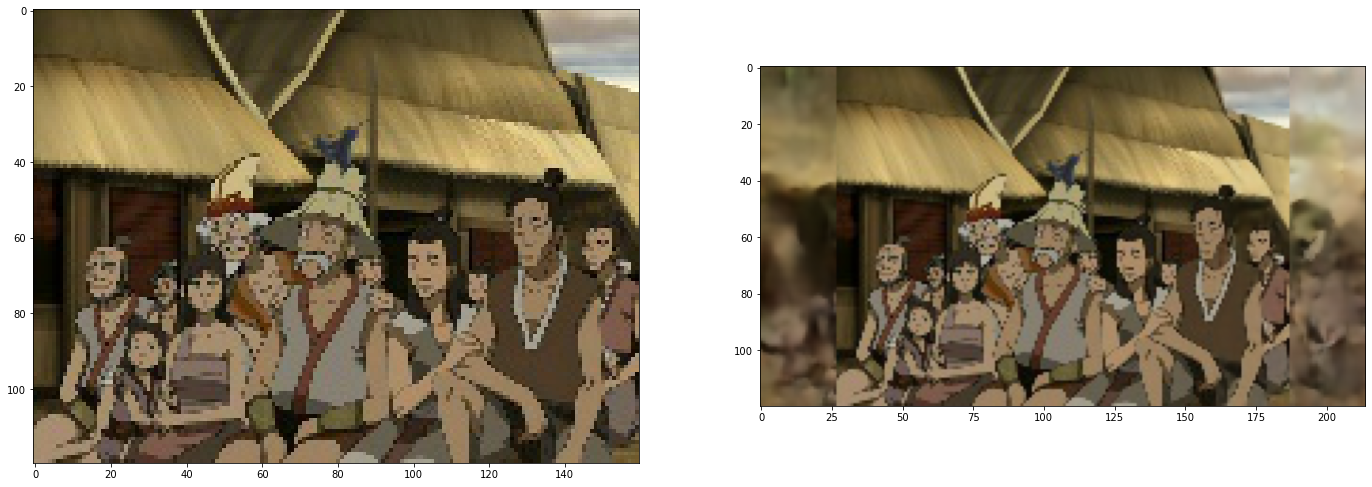

In [58]:
random_names = os.listdir(data_dir+'X')
image_name = random_names[random.randint(0, len(random_names))]
image_x = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'X', image_name)), dtype=float)
image_y_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'Y', image_name)), dtype=float)
image_y_pred = autoencoder(np.expand_dims(image_x,axis=0))
image_x_flip = np.flip(image_x, axis=1)
image_y_pred_flip = autoencoder(np.expand_dims(image_x_flip,axis=0))
image_y_pred_flip = np.flip(image_y_pred_flip[0], axis=1)

image_true = np.concatenate((image_x, image_y_true), axis=1)
image_pred = np.concatenate((image_x, image_y_pred[0]), axis=1)
image_y_pred_extended = autoencoder(np.expand_dims(image_pred[:,-133:,:],axis=0))
image_pred = np.concatenate((image_pred, image_y_pred_extended[0]), axis=1)
image_pred = np.concatenate((image_y_pred_flip, image_pred), axis=1)

plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_true)
ax = plt.subplot(10, 10, 2)
plt.imshow(image_pred)

In [8]:
adam = Adam(learning_rate=learning_rate*0.1)
autoencoder.compile(optimizer=adam, loss='mean_absolute_error')

In [9]:
files = os.listdir(data_dir+'X')
gen_loader = DataGenerator(files, batch_size=batch_size)
autoencoder.fit(gen_loader, epochs=epochs,
            use_multiprocessing=True, workers=workers, shuffle=True)

Epoch 1/150
3094/3095 [============================&gt;.] - ETA: 0s - loss: 0.0165WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.
3095/3095 [==============================] - 1211s 391ms/step - loss: 0.0165
Epoch 2/150
   4/3095 [..............................] - ETA: 16:00 - loss: 0.0162Process Keras_worker_ForkPoolWorker-22:
Process Keras_worker_ForkPoolWorker-23:
Process Keras_worker_ForkPoolWorker-21:
Process Keras_worker_ForkPoolWorker-19:
Process Keras_worker_ForkPoolWorker-24:
Process Keras_worker_ForkPoolWorker-18:
Process Keras_worker_ForkPoolWorker-17:
Process Keras_worker_ForkPoolWorker-20:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File &quot;/home/tamim/an

KeyboardInterrupt: 

In [86]:
autoencoder.save_weights('saved_models/'+name+'-l-mix')

(120, 160, 3)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(120, 187, 3)


&lt;matplotlib.image.AxesImage at 0x7f275b9ac4c0&gt;

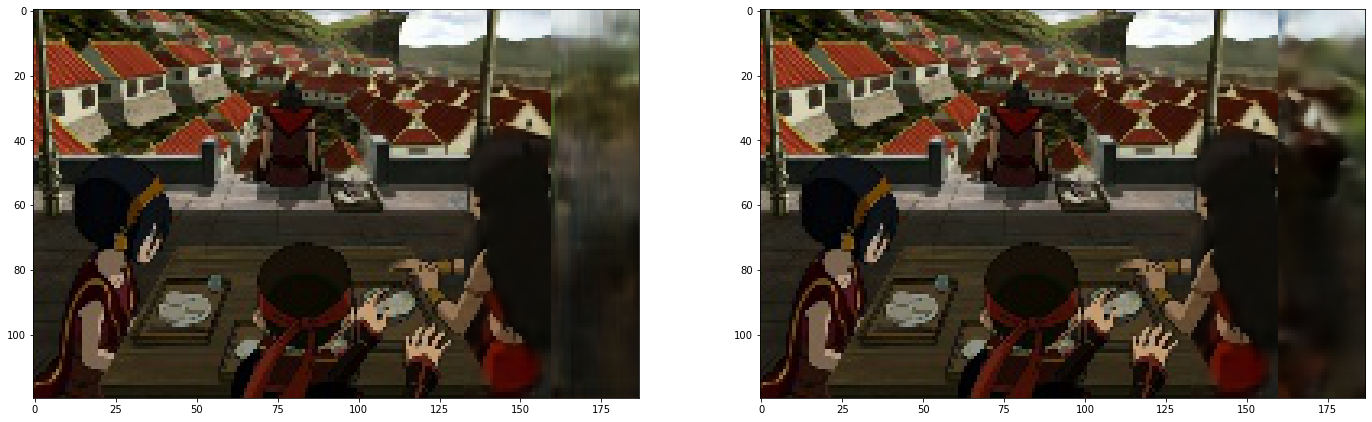

In [85]:
random_names = os.listdir(data_dir+'X')
image_name = random_names[random.randint(0, len(random_names))]
image_x = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'X', image_name)), dtype=float)
image_y_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir+'Y', image_name)), dtype=float)
image_y_pred = autoencoder(np.expand_dims(image_x,axis=0))

image_pred = np.concatenate((image_x, image_y_pred[0]), axis=1)
image_y_pred = autoencoder(np.expand_dims(image_pred[:,27:,:],axis=0))
image_pred_2 = np.concatenate((image_pred, image_y_pred[0]), axis=1)

print(image_pred.shape)
for i in range(27):
    slice_pred = autoencoder(np.expand_dims(image_pred[:,27+i:,:],axis=0))[0]
    #print(-27+i)
    slice_pred = np.expand_dims(slice_pred[:,-1,:], axis=1)
    image_pred = np.concatenate((image_pred, slice_pred), axis=1)

print(image_pred.shape)

plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_pred)
ax = plt.subplot(10, 10, 2)
plt.imshow(image_pred_2)